<a href="https://colab.research.google.com/github/howakuro/GridWorld/blob/master/GridWorld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##各種インポート
**実行するに当たって用意すべき環境**<br>
Python3<br>
matplotlib<br>
numpy<br>
</p>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import random

##崖歩きGridWorld環境クラス

In [0]:
class Env():
    def __init__(self,start = [0,0], goal=[0,4], width = 5, height = 5):
        self.width = width #0 <= x < width
        self.height = height #0 <= y < height
        self.clif = [[height - 1,x] for x in range(1,self.width - 1)]
        self.start = start#初期位置
        self.goal = goal#ゴール地点
        self.point = self.start#現在位置

    #現在状態の取得
    def get_state(self):
        return self.point

    #リセット
    def reset(self):
        self.point = self.start

    #行動番号を実際に移動する数値に変換する
    def action_convert(self,act):
        if act == 0:#上
            return np.array([-1,0])
        if act == 1:#右
            return np.array([0, 1])
        if act == 2:#左
            return np.array([0,-1])
        if act == 3:#下
            return np.array([1, 0])

    #報酬獲得関数
    def get_reward(self):
        if self.point == self.goal:#ゴール時報酬
            return 1
        if self.point in self.clif:#崖に落ちてしまった場合
            return -1
        if not(0 <= self.point[0] < self.height and 0 <= self.point[1] < self.width):#フィールド範囲外に出てしまった場合
            return -1
        return 0#その他

    #実際に行動を行い、報酬と予想される次の状態を取得する   
    def step(self,act):
        move = self.action_convert(act)
        nextpoint = list(np.array(self.point) + move)
        if self.point in self.clif:#フィールド範囲外に出てしまった場合
            nextpoint = self.start
        if not(0 <= nextpoint[0] < self.height and 0 <= nextpoint[1] < self.width):
            nextpoint = self.point
        return self.get_reward(), nextpoint
    
    #次の状態へ更新
    def update_state(self,nextpoint):
        self.point = nextpoint

##価値関数クラス

###Q学習

In [0]:
class Q_Learning():
    def __init__(self, width = 5,height = 5,alpha = 0.1,gamma = 0.9):
        self.width = width
        self.height = height
        self.alpha = alpha
        self.gamma = gamma

    #Q_Learningクラスの初期化
    def reset(self):
        self.init_qtable()

    #Qテーブルを初期化
    def init_qtable(self):
        self.qtable =[[[random.random() for action in range(4)] for width in range(self.width)] for height in range(self.height)] 

    #ある状態のQ値のリストを取得
    def get_q(self,state):
        return self.qtable[state[0]][state[1]]
    
    #Qテーブル全体を取得
    def get_qtable(self):
        return self.qtable

    #Qテーブルの更新
    def update(self,state,action,reward,next_state):
        td_error = reward + self.gamma * max(self.qtable[next_state[0]][next_state[1]]) - self.qtable[state[0]][state[1]][action] 
        self.qtable[state[0]][state[1]][action] += self.alpha * td_error


###SARSA

In [0]:
class SARSA(Q_Learning):
    def __init__(self, width = 5,height = 5,alpha = 0.1,gamma = 0.9):
        super().__init__(width=width, height=height, alpha=alpha, gamma=gamma)

    #Qテーブルの更新
    def update(self,state,action,reward,next_state,next_action):
        td_error = reward + self.gamma * self.qtable[next_state[0]][next_state[1]][next_action] - self.qtable[state[0]][state[1]][action] 
        self.qtable[state[0]][state[1]][action] += self.alpha * td_error

##方策関数クラス

###ε減衰型ε-Greedyクラス

In [0]:
class Decay_E_Greedy():
    #初期化
    def __init__(self,epsilon = 1.0,decay_num = 0.001):
        self.start_epsilon = epsilon
        self.epsilon = self.start_epsilon
        self.decay_num = decay_num

    #シミュレートごとのパラメータリセット
    def reset(self):
        self.epsilon = self.start_epsilon

    #エピソードごとにパラメータを更新、またはリセットする関数:
    def episode_reset(self):
        self.epsilon -= self.decay_num
    
    #行動選択
    def select_action(self,state,value_func):
        if random.random() >= self.epsilon:
            return np.argmax(value_func)
        else:
            return np.random.randint(0,3)

###Greedyクラス

In [0]:
class Greedy(Decay_E_Greedy):
    def __init__(self):
        super().__init__(epsilon = 0.0, decay_num = 0.0)

###ε-Greedyクラス

In [0]:
class E_Greedy(Decay_E_Greedy):
    def __init__(self,epsilon = 0.1):
        super().__init__(epsilon = epsilon, decay_num = 0.0)

##エージェントクラス

In [0]:
class Agent():
    def __init__(self,value = "Q_Learning",policy = "e-greedy",start = [0,0], goal=[4,4], width = 5, height = 5, gamma = 0.9, alpha = 0.1,episode = 100):
        self.env = Env(start=start,goal=goal,width=width,height=height)
        self.value = value 
        if value == "Q_Learning":
            self.value_func = Q_Learning(width = width,height = height,alpha=alpha,gamma=gamma)
        if value == "SARSA":
            self.value_func = SARSA(width = width,height = height,alpha=alpha,gamma=gamma)
        if policy == "greedy":
            self.policy = Greedy()
        if policy == "e-greedy":
            self.policy = E_Greedy(epsilon = 0.3)
        if policy == "decay_e-greedy":
            self.policy = Decay_E_Greedy(epsilon=1.0,decay_num=(1.0/episode))
    
    #環境から状態を取得する
    def get_state(self):
        return self.env.get_state()

    #行動を選択する
    def select_action(self,state):
        q_list = self.value_func.get_q(state)
        return self.policy.select_action(state,q_list)

    #エージェントの価値関数を更新する
    def update(self,state,action,reward,next_state,next_action):
        if self.value == "Q_Learning":
            self.value_func.update(state,action,reward,next_state)
        if self.value == "SARSA":
            self.value_func.update(state,action,reward,next_state,next_action)
    
    #qテーブルを取得する
    def get_qtable(self):
        return self.value_func.get_qtable()

    #1ステップ進める
    def step(self,act):
        return self.env.step(act)
    
    #環境の状態を更新する
    def update_state(self,next_state):
        self.env.update_state(next_state)

    #シミュレーションが終わったので価値関数と方策関数をリセット
    def sim_reset(self):
        self.policy.reset()
        self.value_func.reset()

    #エピソードが終了したので環境をリセット
    def episode_reset(self):
        self.policy.episode_reset()
        self.env.reset()

##Printクラス

In [0]:
#各種描画
class Print():
    @classmethod
    def print_q(self,q_table,width,height):
        for i in range(height):
            for j in range(width):
                print("[ ",end="")
                for k in range(4):
                    if q_table[i][j][k] > 0:
                        print(f" {q_table[i][j][k]:.2f} ",end="")
                    else:
                        print(f"{q_table[i][j][k]:.2f} ",end="")
                print("]",end="")
            print("")

    @classmethod
    def print_graph(self,sim_num,policyname_list,valuename_list,step_time_list):
        num = 0
        for value in valuename_list:
            for policy in policyname_list:
                plt.plot(step_time_list[num]/sim_num,label = policy+","+value)
                num += 1
        plt.legend()
        plt.title("Steptime / Episode")
        plt.xlabel("episode")
        plt.ylabel("Steptime")
        plt.show()
        
    @classmethod
    def move_print(self,q_table,height,width):
        vector = {0:"↑",1:"→",2:"←",3:"↓"}
        for i in range(height):
            for j in range(width):
                print(vector[np.argmax(q_table[i][j])],end="")
            print("")

##シミュレート関数

In [0]:
def simulate(sim_num,epi_num,step_num,width,height,start,goal,policy,value):
    print(f"【{policy},{value}】")
    step_time = np.zeros(epi_num, dtype=int)#1エピソードでゴールにかかった回数
    agent = Agent(value = value,policy = policy,start = start, goal= goal, width = width, height = height,episode = epi_num)
    for i in range(sim_num):
        agent.sim_reset()
        for j in range(epi_num):
            agent.episode_reset()
            #print("episode_num:",j)
            state = agent.get_state()
            act = agent.select_action(state)
            for k in range(step_num):
                reward,nextstate = agent.step(act)
                next_act = agent.select_action(nextstate)
                agent.update(state,act,reward,nextstate,next_act)
                if state == goal:
                    break
                agent.update_state(nextstate)
                state = agent.get_state()
                act = next_act
            step_time[j] += k
    print("【Q値の表示】")
    Print.print_q(agent.get_qtable(),width,height)
    print("【各地点において移動する方向】")
    Print.move_print(agent.get_qtable(),height,width)
    print("【エピソードごとのステップ数】")
    print(step_time/sim_num,"\n")
    return step_time

【greedy,Q_Learning】
[[7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 7], [7, 8], [7, 9], [7, 10]]
【Q値の表示】
[  0.03  0.03  0.03  0.03 ][  0.03  0.03  0.03  0.03 ][  0.03  0.03  0.03  0.03 ][  0.03  0.03  0.03  0.03 ][  0.03  0.03  0.03  0.03 ][  0.03  0.03  0.03  0.03 ][  0.03  0.03  0.03  0.03 ][  0.03  0.03  0.03  0.03 ][  0.03  0.03  0.03  0.03 ][  0.03  0.03  0.03  0.03 ][  0.04  0.04  0.04  0.04 ][  0.04  0.04  0.04  0.04 ]
[  0.03  0.03  0.03  0.03 ][  0.03  0.03  0.03  0.03 ][  0.03  0.03  0.03  0.03 ][  0.03  0.03  0.03  0.03 ][  0.03  0.03  0.03  0.03 ][  0.03  0.03  0.03  0.03 ][  0.03  0.03  0.03  0.03 ][  0.03  0.03  0.03  0.03 ][  0.03  0.03  0.03  0.03 ][  0.03  0.03  0.03  0.03 ][  0.03  0.03  0.03  0.04 ][  0.04  0.04  0.04  0.04 ]
[  0.03  0.03  0.01  0.03 ][  0.03  0.03  0.03  0.03 ][  0.03  0.03  0.03  0.03 ][  0.03  0.03  0.01  0.03 ][  0.03  0.02  0.03  0.03 ][  0.03  0.03  0.03  0.03 ][  0.03  0.03  0.03  0.03 ][  0.03  0.03  0.03  0.03 ][  0.03  0.03  0.03  0.0

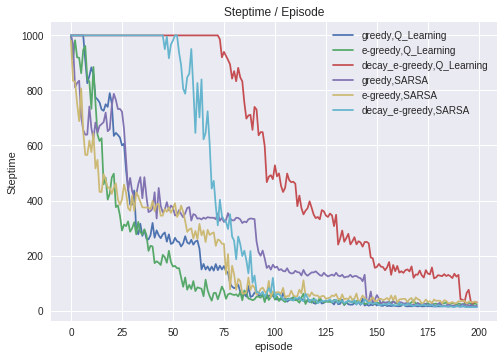

In [38]:
SIMULATE_TIMES = 10
EPISODE_TIMES = 200
STEP_TIMES = 1000
WIDTH = 12
HEIGHT = 8
START = [HEIGHT - 1, 0]
GOAL = [HEIGHT-1, WIDTH-1]
VALUE = [
         "Q_Learning",
         "SARSA",        
        ]
POLICY = [
          "greedy",
          "e-greedy",
          "decay_e-greedy",
         ]
all_policy_step_time = []
for value in VALUE:
    for policy in POLICY:
        step_time = np.array(simulate(SIMULATE_TIMES,EPISODE_TIMES,STEP_TIMES,WIDTH,HEIGHT,START,GOAL,policy,value))
        all_policy_step_time.append(step_time)
        
Print.print_graph(SIMULATE_TIMES,POLICY,VALUE,all_policy_step_time)